## Tobigs 2주차 Optimization 과제
#### 15기 이윤정

----
# Gradient Descent 구현하기
 1)"..."표시되어 있는 빈 칸을 채워주세요  
 2)강의내용과 코드에 대해 공부한 내용을 마크마운 또는 주석으로 설명해주세요

## 데이터

In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
data = pd.read_csv('assignment_2.csv')
data.head()

,Label,bias,experience,salary
0,1,1,0.7,48000
1,0,1,1.9,48000
2,1,1,2.5,60000
3,0,1,4.2,63000
4,0,1,6.0,76000


## Train Test 데이터 나누기

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
#0.25 : 0.75로 분할
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0], test_size = 0.25, random_state = 0)

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((150, 3), (50, 3), (150,), (50,))

## Scaling

experience와 salary의 단위, 평균, 분산이 크게 차이나므로 scaler를 사용해 단위를 맞춰줍니다. 

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
bias_train = X_train["bias"]
bias_train = bias_train.reset_index()["bias"]
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_train["bias"] = bias_train
X_train.head()

,bias,experience,salary
0,1,0.187893,-1.143335
1,1,1.185555,0.043974
2,1,-0.310938,-0.351795
3,1,-1.629277,-1.341220
4,1,-1.308600,0.043974


이때, scaler는 X_train에 fit되었으므로 X_test를 scaling할 때에는 transform만 해주면 된다. 

In [7]:
bias_test = X_test["bias"]
bias_test = bias_test.reset_index()["bias"]
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
X_test["bias"] = bias_test
X_test.head()

,bias,experience,salary
0,1,-1.344231,-0.615642
1,1,0.508570,0.307821
2,1,-0.310938,0.571667
3,1,1.363709,1.956862
4,1,-0.987923,-0.747565


In [8]:
# parameter 개수
N = len(X_train.loc[0])

In [9]:
# 초기 parameter들을 임의로 설정해줍니다.
parameters = np.array([random.random() for i in range(N)])
random_parameters = parameters.copy()
parameters

array([0.91566618, 0.9621985 , 0.058322  ])

### * LaTeX   

Jupyter Notebook은 LaTeX 문법으로 수식 입력을 지원하고 있습니다.  
LaTeX문법으로 아래의 수식을 완성해주세요  
http://triki.net/apps/3466  
https://jjycjnmath.tistory.com/117

## Dot product
## $z = X_i \theta$

In [10]:
def dot_product(X, parameters):
    z = 0
    for i in range(len(parameters)):
        z += X[i]*parameters[i]
    return z

내적 함수 이다. 

## Logistic Function

## $p = 1/(1+e^{-\beta *X})$

In [11]:
def logistic(X, parameters):
    z = dot_product(X, parameters)
    p = 1/(1 + np.exp(-z))
    return p

sigmoid function로 불리며, 수식 상의 $\beta*X$는 Z로 표현되기도 한다.  
sigmoid function은 0에서 1 사이의 값만은 output으로 갖기 때문에 binary classification 혹은 확률 P를 나타내는 데 사용된다.

In [12]:
logistic(X_train.iloc[1], parameters)

0.8868508832739671

## Object function

Object Function : 목적함수는 Gradient Descent를 통해 최적화 하고자 하는 함수입니다.  
<br>
선형 회귀의 목적함수
## $l(\theta) = \frac{1}{2}\Sigma(y_i - \theta^{T}X_i)^2$  
참고) $\hat{y_i} = \theta^{T}X_i$
  
로지스틱 회귀의 목적함수
## $l(p) =-\sum \left \{ y_{i}logp + (1-y_{i})log(1-p)  \right \}$

MSE를 목적함수 (=비용함수)로 사용하는 linear regression과 달리 logistic regression은 목적함수로 MSE를 사용하지 않는다. MSE를 목적함수로 Gradiant Descent 사용 시 Convex function이 아니게 되어 찾고자하는 최솟값이 아닌 다른 최솟값에 도달할 수 있기 때문이다.  
<br>
따라서, MSE를 대체할 수 있는 목적함수를 찾은 결과, 다음 조건을 만족한다.  
       $if, y = 1\rightarrow cost(p,y) = −log(p)$  
       $if, y = 0\rightarrow cost(p,y) = −log(1-p)$

In [13]:
def minus_log_cross_entropy_i(X, y, parameters):
    p = logistic(X, parameters)
    loss = (y*np.log(p)+(1-y)*np.log(1-p))
    return -loss

In [14]:
def mse_i(X, y, parameters):
    y_hat = dot_product(X, parameters.T)
    loss = np.square(np.subtract(y,y_hat))/2  
    return loss

In [15]:
def batch_loss(X_set, y_set, parameters, loss_function, n): #n:현재 배치의 데이터 수
    loss = 0
    for i in range(X_set.shape[0]):
        X = X_set.iloc[i,:]
        y = y_set.iloc[i]
        loss += loss_function(X, y, parameters)
    loss = loss/n #loss 평균값으로 계산
    return loss

In [16]:
batch_loss(X_test, y_test, parameters, minus_log_cross_entropy_i, len(X_test))

1.2622088980367838

## Gradient
위의 선형회귀의 목적함수 $l(\theta)$와 로지스틱회귀의 목적함수 $l(p)$의 gradient를 작성해주세요.

## ${\partial\over{\partial \theta_j}}l(\theta)=\frac{1}{2}\Sigma(y_i - \theta^{T}X_i)X_{ij}$  
## ${\partial\over{\partial \theta_j}}l(p)=-\sum \left ( y_{i}-p_{i} \right )x_{ij}$ 

In [17]:
def get_gradient_ij(X, y, parameters, j, model):
    if model == 'linear':
        y_hat = dot_product(X, parameters)
        gradient = (y-y_hat)*X[j]/2
    else:
        p = logistic(X, parameters)
        gradient = -(y-p)*X[j]
    return gradient

In [18]:
get_gradient_ij(X_train.iloc[0,:], y_train.iloc[0], parameters, 1, 'logistic')

-0.04943986877732968

## Batch Gradient
배치 경사 하강법이란 매 경사 하강법 step에서 전체 훈련 세트 X에 대해 계산하는 기법으로, 특성 수에 민감하지 않지만 훈련 세트가 클수록 속도가 느려지는 단점이 존재한다. 

In [19]:
def batch_gradient(X_set, y_set, parameters, model):
    gradients = [0 for i in range(len(parameters))]
    
    for i in range(len(X_set)):
        X = X_set.iloc[i,:]
        y = y_set.iloc[i]
        for j in range(len(parameters)):
            gradients[j] += get_gradient_ij(X, y, parameters, j, model)
    
    return gradients

In [20]:
gradients1 = batch_gradient(X_train, y_train, parameters, 'logistic')
gradients1

[59.56350891660878, 9.874540091268805, 35.34245639055461]

## mini-batch
미니 배치라 불리우는 임의의 작은 샘플 세트에 대해 그레디언트를 계산하는 기법이다.

In [21]:
def batch_idx(X_train, batch_size):
    N = len(X_train)
    nb = (N // batch_size)+1 #number of batch
    idx = np.array([i for i in range(N)])
    idx_list = [idx[i*batch_size:(i+1)*batch_size] for i in range(nb) if len(idx[i*batch_size:(i+1)*batch_size]) != 0]
    return idx_list

batch_idx 함수에 대한 설명을 batch_size와 함께 간략하게 작성해주세요  
- batch_idx 함수는 parameter로 입력받은 batch_size를 기준으로 데이터를 인덱싱하여 미니배치로 만든다음 그레디언트를 계산하는 함수이다. 
- 미니배치를 어느 정도 크게 하면 Stochastic Gradient Descent(SGD)보다 최솟값에 더 가까이 도달할 수 있다고 한다. 다만, 해당 최솟값이 local minimum일 경우 빠져나오는 데 더 힘들다.

## Update Parameters
기울기를 갱신하는 코드를 작성해주세요  
(loss와 마찬가지로 기울기를 갱신할 때 배치 사이즈를 고려해 평균으로 갱신해주세요)

In [22]:
def step(parameters, gradients, learning_rate, n): #n:현재 배치의 데이터 수
    for i in range(len(parameters)):
        gradients[i] *= learning_rate
    
    parameters -= gradients
    return parameters/n

In [23]:
step(parameters, gradients1, 0.01, len(X_train))

array([ 0.00213354,  0.00575635, -0.00196735])

## Gradient Descent
위에서 작성한 함수들을 조합해서 경사하강법 함수를 완성해주세요

- learning_rate: 학습률  
- tolerance: Step이 너무 작아서 더 이상의 학습이 무의미할 때 학습을 멈추는 조건  
- batch: 기울기를 1번 갱신할 때 사용하는 데이터셋  
- epoch: 한 반복에서 훈련 세트의 샘플 수만큼 반복되는 데, 이때 각 반복을 의미
- num_epoch: 최대반복횟수 
<br>

BGD: 학습 한 번에 모든 데이터셋에 대해 기울기를 구한다.    
SGD: 학습 한 번에 임의의 데이터에 대해서만 기울기를 구한다.   
MGD: 학습 한 번에 데이터셋의 일부에 대해서만 기울기를 구한다.    

<br>
batch_size에 따른 경사하강법의 종류를 적어주세요. <br>      
batch_size=1 -> SGD  <br>
batch_size=k -> MGD  <br>
batch_size=whole -> BGD       

In [24]:
def gradient_descent(X_train, y_train, learning_rate = 0.1, num_epoch = 1000, tolerance = 0.00001, model = 'logistic', batch_size = 16):
    stopper = False
    
    N = len(X_train.iloc[0])
    parameters = np.random.rand(N)
    loss_function = minus_log_cross_entropy_i if model == 'logistic' else mse_i
    loss = 999
    batch_idx_list = batch_idx(X_train, batch_size)
    
    for epoch in range(num_epoch):
        if stopper:
            break
        for idx in batch_idx_list:
            X_batch = X_train.iloc[idx,]
            y_batch = y_train.iloc[idx]
            gradients = batch_gradient(X_batch, y_batch, parameters, model)
            parameters = step(parameters, gradients, learning_rate, N)
            new_loss = batch_loss(X_batch, y_batch, parameters, loss_function, N)
            
            #중단 조건
            if abs(new_loss - loss) < tolerance:
                stopper = True
                break
            loss = new_loss
        
        #100epoch마다 학습 상태 출력
        if epoch%100 == 0: #출력이 길게 나오면 check point를 수정해도 됩니다.
            print(f"epoch: {epoch}  loss: {new_loss}  params: {parameters}  gradients: {gradients}")
    
    return parameters

## Implement
경사하강법 함수를 이용해 최적의 모수 찾아보세요. 학습을 진행할 때, Hyper Parameter를 바꿔가면서 학습시켜보세요.

## Logistic Regression

#### 1. learning_rate = 0.1, num_epoch = 1000, tolerance = 0.00001

In [25]:
new_param_bgd = gradient_descent(X_train, y_train, learning_rate = 0.1, num_epoch = 1000, tolerance = 0.00001, model = 'logistic', batch_size = 150)
new_param_bgd

epoch: 0  loss: 37.20965756174921  params: [-1.17594477 -0.37162372 -1.42731724]  gradients: [3.7036214444914677, 1.9438373659170158, 4.872363898991582]
epoch: 100  loss: 41.114250556074424  params: [-0.78162073 -0.40970799 -1.62517229]  gradients: [1.5175081326540993, 2.925377337405446, 5.283478944677073]
epoch: 200  loss: 41.114250556074424  params: [-0.78162073 -0.40970799 -1.62517229]  gradients: [1.5175081326540993, 2.925377337405446, 5.283478944677073]
epoch: 300  loss: 41.114250556074424  params: [-0.78162073 -0.40970799 -1.62517229]  gradients: [1.5175081326540993, 2.925377337405446, 5.283478944677073]
epoch: 400  loss: 41.114250556074424  params: [-0.78162073 -0.40970799 -1.62517229]  gradients: [1.5175081326540993, 2.925377337405446, 5.283478944677073]
epoch: 500  loss: 41.114250556074424  params: [-0.78162073 -0.40970799 -1.62517229]  gradients: [1.5175081326540993, 2.925377337405446, 5.283478944677073]
epoch: 600  loss: 41.114250556074424  params: [-0.78162073 -0.40970799 -

array([-0.82735406,  1.69625338,  0.40796209])

In [26]:
new_param_sgd = gradient_descent(X_train, y_train, learning_rate = 0.1, num_epoch = 1000, tolerance = 0.00001, model = 'logistic', batch_size = 1)
new_param_sgd

epoch: 0  loss: 0.22254266312583326  params: [-0.0238071   0.01267756  0.01305256]  gradients: [0.05034448072168998, -0.051530288191216134, -0.05756060462097561]


array([-0.0238071 ,  0.01267756,  0.01305256])

In [27]:
new_param_mgd = gradient_descent(X_train, y_train, learning_rate = 0.1, num_epoch = 1000, tolerance = 0.00001, model = 'logistic', batch_size = 72)
new_param_mgd

epoch: 0  loss: 1.2227073317837822  params: [-0.17763866  0.10812902 -0.1382262 ]  gradients: [0.19178808909849174, 0.18595917534256212, 0.26110984485577965]
epoch: 100  loss: 1.178571863811982  params: [-0.16632678  0.06529327 -0.17764872]  gradients: [0.14843344163115302, 0.13744379272266383, 0.21105211535354906]
epoch: 200  loss: 1.178571863811982  params: [-0.16632678  0.06529327 -0.17764872]  gradients: [0.14843344163115302, 0.13744379272266383, 0.21105211535354906]
epoch: 300  loss: 1.178571863811982  params: [-0.16632678  0.06529327 -0.17764872]  gradients: [0.14843344163115302, 0.13744379272266383, 0.21105211535354906]
epoch: 400  loss: 1.178571863811982  params: [-0.16632678  0.06529327 -0.17764872]  gradients: [0.14843344163115302, 0.13744379272266383, 0.21105211535354906]
epoch: 500  loss: 1.178571863811982  params: [-0.16632678  0.06529327 -0.17764872]  gradients: [0.14843344163115302, 0.13744379272266383, 0.21105211535354906]
epoch: 600  loss: 1.178571863811982  params: [-

array([-0.16632678,  0.06529327, -0.17764872])

---
#### 2. learning_rate = 0.001, num_epoch = 1000, tolerance = 0.00001
learning_rate 감소

In [28]:
new_param_bgd = gradient_descent(X_train, y_train, learning_rate = 0.001, num_epoch = 1000, tolerance = 0.00001, model = 'logistic', batch_size = 150)
new_param_bgd

epoch: 0  loss: 39.109926228538164  params: [0.27906126 0.20062851 0.23618959]  gradients: [0.056656073749902634, 0.012853213858945271, 0.045055759689370915]


array([-0.01619598,  0.00897059, -0.00701795])

In [29]:
new_param_sgd = gradient_descent(X_train, y_train, learning_rate = 0.001, num_epoch = 1000, tolerance = 0.00001, model = 'logistic', batch_size = 1)
new_param_sgd

epoch: 0  loss: 0.2310164601019148  params: [-1.95901080e-04 -8.85473287e-07  6.16932353e-06]  gradients: [0.0005000037091515999, 0.00021865591293377553, 5.496843447179911e-05]


array([-1.95901080e-04, -8.85473287e-07,  6.16932353e-06])

In [30]:
new_param_mgd = gradient_descent(X_train, y_train, learning_rate = 0.001, num_epoch = 1000, tolerance = 0.00001, model = 'logistic', batch_size = 72)
new_param_mgd

epoch: 0  loss: 1.3984170002048792  params: [ 0.01483096  0.00635273 -0.00179549]  gradients: [0.002091874387531021, 0.0018306458051498976, 0.0026765617434228806]
epoch: 100  loss: 1.3833247456167503  params: [-0.0029433   0.00094763 -0.00180727]  gradients: [0.0019917714333218613, 0.0017420531519985875, 0.002587666675657426]
epoch: 200  loss: 1.3833247456167503  params: [-0.0029433   0.00094763 -0.00180727]  gradients: [0.0019917714333218613, 0.0017420531519985875, 0.002587666675657426]
epoch: 300  loss: 1.3833247456167503  params: [-0.0029433   0.00094763 -0.00180727]  gradients: [0.0019917714333218613, 0.0017420531519985875, 0.002587666675657426]
epoch: 400  loss: 1.3833247456167503  params: [-0.0029433   0.00094763 -0.00180727]  gradients: [0.0019917714333218613, 0.0017420531519985875, 0.002587666675657426]
epoch: 500  loss: 1.3833247456167503  params: [-0.0029433   0.00094763 -0.00180727]  gradients: [0.0019917714333218613, 0.0017420531519985875, 0.002587666675657426]
epoch: 600  

array([-0.0029433 ,  0.00094763, -0.00180727])

---
#### 3. learning_rate = 0.001, num_epoch = 10000, tolerance = 0.00001
num_epoch 증가

In [68]:
new_param_bgd = gradient_descent(X_train, y_train, learning_rate = 0.001, num_epoch = 10000, tolerance = 0.00001, model = 'logistic', batch_size = 150)
new_param_bgd

epoch: 0  loss: 35.40382965281298  params: [0.04504435 0.21445238 0.16288371]  gradients: [0.03753312260183264, 0.014891746369915963, 0.045275049403989284]


array([-0.01619562,  0.00897234, -0.00701683])

In [32]:
new_param_sgd = gradient_descent(X_train, y_train, learning_rate = 0.001, num_epoch = 10000, tolerance = 0.00001, model = 'logistic', batch_size = 1)
new_param_sgd

epoch: 0  loss: 0.23101645333771778  params: [-1.95941948e-04 -8.96843797e-07  6.21709029e-06]  gradients: [0.000500003678700575, 0.000218655899617281, 5.49684311241336e-05]


array([-1.95941948e-04, -8.96843797e-07,  6.21709029e-06])

In [33]:
new_param_mgd = gradient_descent(X_train, y_train, learning_rate = 0.001, num_epoch = 10000, tolerance = 0.00001, model = 'logistic', batch_size = 72)
new_param_mgd

epoch: 0  loss: 1.419735995452209  params: [0.01377913 0.03572546 0.00325892]  gradients: [0.0022133510542920445, 0.001973424222884731, 0.002813518296844626]
epoch: 100  loss: 1.3833247456167503  params: [-0.0029433   0.00094763 -0.00180727]  gradients: [0.0019917714333218613, 0.0017420531519985875, 0.002587666675657426]
epoch: 200  loss: 1.3833247456167503  params: [-0.0029433   0.00094763 -0.00180727]  gradients: [0.0019917714333218613, 0.0017420531519985875, 0.002587666675657426]
epoch: 300  loss: 1.3833247456167503  params: [-0.0029433   0.00094763 -0.00180727]  gradients: [0.0019917714333218613, 0.0017420531519985875, 0.002587666675657426]
epoch: 400  loss: 1.3833247456167503  params: [-0.0029433   0.00094763 -0.00180727]  gradients: [0.0019917714333218613, 0.0017420531519985875, 0.002587666675657426]
epoch: 500  loss: 1.3833247456167503  params: [-0.0029433   0.00094763 -0.00180727]  gradients: [0.0019917714333218613, 0.0017420531519985875, 0.002587666675657426]
epoch: 600  loss:

epoch: 5000  loss: 1.3833247456167503  params: [-0.0029433   0.00094763 -0.00180727]  gradients: [0.0019917714333218613, 0.0017420531519985875, 0.002587666675657426]
epoch: 5100  loss: 1.3833247456167503  params: [-0.0029433   0.00094763 -0.00180727]  gradients: [0.0019917714333218613, 0.0017420531519985875, 0.002587666675657426]
epoch: 5200  loss: 1.3833247456167503  params: [-0.0029433   0.00094763 -0.00180727]  gradients: [0.0019917714333218613, 0.0017420531519985875, 0.002587666675657426]
epoch: 5300  loss: 1.3833247456167503  params: [-0.0029433   0.00094763 -0.00180727]  gradients: [0.0019917714333218613, 0.0017420531519985875, 0.002587666675657426]
epoch: 5400  loss: 1.3833247456167503  params: [-0.0029433   0.00094763 -0.00180727]  gradients: [0.0019917714333218613, 0.0017420531519985875, 0.002587666675657426]
epoch: 5500  loss: 1.3833247456167503  params: [-0.0029433   0.00094763 -0.00180727]  gradients: [0.0019917714333218613, 0.0017420531519985875, 0.002587666675657426]
epoc

array([-0.0029433 ,  0.00094763, -0.00180727])

---
#### 4. learning_rate = 0.001, num_epoch = 10000, tolerance = 0.001
tolerance 감소  
- 그레디언트 벡터의 norm이 허용오차(tolerance)보다 작아지면 GD가 거의 최솟값에 도달했으므로, tolerance가 감소하면 그만큼 반복횟수는 증가한다.

In [76]:
new_param_bgd = gradient_descent(X_train, y_train, learning_rate = 0.001, num_epoch = 10000, tolerance = 0.001, model = 'logistic', batch_size = 150)
new_param_bgd

epoch: 0  loss: 38.06035086364299  params: [0.2717144  0.03807513 0.03337958]  gradients: [0.06371172972602104, -0.012209085559385031, 0.020048401243791973]


array([-0.016164  ,  0.00897274, -0.00701429])

In [70]:
new_param_sgd = gradient_descent(X_train, y_train, learning_rate = 0.001, num_epoch = 10000, tolerance = 0.001, model = 'logistic', batch_size = 1)
new_param_sgd

epoch: 0  loss: 0.23106993808119988  params: [0.00096048 0.00064257 0.0001283 ]  gradients: [0.0005004335377007417, -0.0006548674299208984, 2.200627525045291e-05]


array([0.00096048, 0.00064257, 0.0001283 ])

In [71]:
new_param_mgd = gradient_descent(X_train, y_train, learning_rate = 0.001, num_epoch = 10000, tolerance = 0.001, model = 'logistic', batch_size = 72)
new_param_mgd

epoch: 0  loss: 1.4241673941106212  params: [0.01735983 0.02148055 0.01518791]  gradients: [0.00222231592119025, 0.001972930990221792, 0.0028252005280486473]


array([-0.00683536,  0.00458756, -0.00283205])

### Predict Label

In [77]:
y_predict = []
for i in range(len(y_test)):
    p = logistic(X_test.iloc[i,:], new_param_bgd)
    if p> 0.5 :
        y_predict.append(1)
    else :
        y_predict.append(0)
y_predict_random = []
for i in range(len(y_test)):
    p = logistic(X_test.iloc[i,:], random_parameters)
    if p> 0.5 :
        y_predict_random.append(1)
    else :
        y_predict_random.append(0)

### Confusion Matrix

In [38]:
from sklearn.metrics import *

In [78]:
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
confusion_matrix(y_test, y_predict)

array([[40,  0],
       [10,  0]], dtype=int64)

In [75]:
accuracy = (tp+tn) / (tp+fn+fp+tn)
print("accuracy:",accuracy)

accuracy: 0.8


## Linear regression
### $y = 0.5 + 2.7x$

### Data

In [41]:
raw_X = np.random.rand(150)
y = 2.7*raw_X + 0.5 + np.random.randn(150)

In [42]:
tmp = np.array([1 for _ in range(150)])
X = np.vstack((tmp, raw_X)).T
X = pd.DataFrame(X)
y = pd.Series(y)

### Estimation

In [43]:
#정규방정식
theta = np.linalg.inv(np.dot(X.T,X)).dot(X.T).dot(y)
theta

array([0.66504227, 2.19750227])

In [59]:
#경사하강법
new_param = gradient_descent(X, y, learning_rate = 0.00005, num_epoch = 100000, tolerance = 0.00001, model = 'linear', batch_size = 150)
new_param

epoch: 0  loss: 114.05489874362357  params: [0.25057012 0.28327068]  gradients: [0.005788771365800701, 0.0037215673353519813]


array([-0.01060924, -0.00641312])

In [60]:
y_hat_NE = theta.dot(X.T)
y_hat_GD = new_param.dot(X.T)

### Visualization
시각화를 통해 정규방정식과 경사하강법을 통한 선형회귀를 비교해보세요  
(밑의 코드를 실행만 시키면 됩니다. 추가 코드 x)

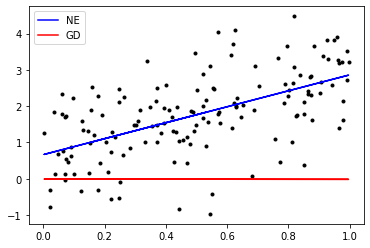

In [61]:
import matplotlib.pyplot as plt
plt.plot(X.iloc[:,1], y, '.k') #산점도
plt.plot(X.iloc[:,1], y_hat_NE, '-b', label = 'NE') #정규방정식
plt.plot(X.iloc[:,1], y_hat_GD, '-r', label = 'GD') #경사하강법
plt.legend()
plt.show()